In [2]:
#essential imports
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize

#scraping imports
import requests
from bs4 import BeautifulSoup

#plotting imports
%matplotlib inline
import matplotlib.pyplot as plt

## 1.  Obtain the 200 top-ranking universities in www.topuniversities.com ([ranking 2018](https://www.topuniversities.com/university-rankings/world-university-rankings/2018)). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the [details page](https://www.topuniversities.com/universities/ecole-polytechnique-fédérale-de-lausanne-epfl).
<br>
** Method **
<font color='MidnightBlue'>
Using the postman plugin on google chrome, we found the json representing the list of the universities:

https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508252855868


We want to scrap those data from the site:
* name 
* rank
* country
* region 
* number of faculty members (international and total)
* number of students (international and total)

In the JSON we retrieved, there is already the **name**, **rank**, **country** and **region**. 

In [3]:
#json to dataframe using panda
json_data = json.load(open('TopUniRanking.json'))
df = json_normalize(json_data['data'])
#the university are sorted by ranks, so we just need the 200 first indexes
dfTopUni200 = df.head(200)
#drop useless column information
dfTopUni200 = dfTopUni200.drop(["cc","core_id","logo","guide"],axis=1)
dfTopUni200.head(5)

country     nid rank_display         region score stars  \
0   United States  294850            1  North America   100     6   
1   United States  297282            2  North America  98.7     5   
2   United States  294270            3  North America  98.4     5   
3   United States  294562            4  North America  97.7     5   
4  United Kingdom  294561            5         Europe  95.6     5   

                                          title  \
0   Massachusetts Institute of Technology (MIT)   
1                           Stanford University   
2                            Harvard University   
3  California Institute of Technology (Caltech)   
4                       University of Cambridge   

                                                 url  
0  /universities/massachusetts-institute-technolo...  
1                  /universities/stanford-university  
2                   /universities/harvard-university  
3  /universities/california-institute-technology-...  
4                 /universities/university-cambridge

** Method **
<font color='MidnightBlue'>
<br>

We now have the general data for the 200 first universities. Then we need to scrap data on each unique page of each university to retrieve those 4 informations: 
* **number of total faculty members** 
* **number of international faculty members**
* **number of total students** 
* **number of international students**

The url of each university is contained in our previous dataFrame. And the link to the pages follow this scheme:  
 **https://www.topuniversities.com+*url*** 
 
Using developper tool in google chrome to inspect the html of the page, we found that the 4 datas we want are located inside unique html objects that have as class: **total faculty**, **inter faculty**, **total student** and **total inter**.
So to find those datas we filter by class name the html page, then we retreive the specific associated information.

<font color='MidnightBlue'>
### **Warning :** the next cell requiers internet to work as intended and it lasts around 2 minutes of computation.

In [4]:
listUrl = dfTopUni200['url']
#create a temporary dataframe
index = range(200)
columns = ["nbr_faculty_members","nbr_international_faculty_members","nbr_total_students","nbr_international_total_students"]
temp_df = pd.DataFrame(index=index,columns=columns)

#helper function that filter the html file and return the int corresponding to the special string htmlClass
#return NaN if the object doesn't exist
def findNumberOf(soup,htmlClass):
    filteredHtmlElements = soup.find_all('div', class_=htmlClass)
    #case if a field information is not given
    if(len(filteredHtmlElements)==0):
        return np.nan
    #find the integer value inside the html balise
    t= filteredHtmlElements[0].find('div', class_='number').text
    #clear the input then convert it into an integer
    return int(t.replace('\n', '').replace('\r', '').replace(',', '').replace(' ',''))

#retrieve the 4 informations needed from the url, for each university
for i,url in enumerate(listUrl):
    finalUrl = "https://www.topuniversities.com"+url
    r = requests.get(finalUrl)
    soup = BeautifulSoup(r.text, 'html.parser')
    #todo: scrap with beautifulSoup using the url
    #merge data into the temp dataframe
    temp_df.nbr_faculty_members[i] = findNumberOf(soup,'total faculty')
    temp_df.nbr_international_faculty_members[i] = findNumberOf(soup,'inter faculty')
    temp_df.nbr_total_students[i] = findNumberOf(soup,'total student')
    temp_df.nbr_international_total_students[i] = findNumberOf(soup,'total inter')

Now that we have all the informations we want into this DataFrame, we merge it with the initial one.

In [5]:
#merge the old dataframe with the new information
#fullDataFrameTopUni200 contains all the information of the 200 top universities from www.topuniversities.com
fullDataFrameTopUni200 = dfTopUni200.join(temp_df)
fullDataFrameTopUni200.head(5)

country     nid rank_display         region score stars  \
0   United States  294850            1  North America   100     6   
1   United States  297282            2  North America  98.7     5   
2   United States  294270            3  North America  98.4     5   
3   United States  294562            4  North America  97.7     5   
4  United Kingdom  294561            5         Europe  95.6     5   

                                          title  \
0   Massachusetts Institute of Technology (MIT)   
1                           Stanford University   
2                            Harvard University   
3  California Institute of Technology (Caltech)   
4                       University of Cambridge   

                                                 url nbr_faculty_members  \
0  /universities/massachusetts-institute-technolo...                2982   
1                  /universities/stanford-university                4285   
2                   /universities/harvard-university                4350   
3  /universities/california-institute-technology-...                 953   
4                 /universities/university-cambridge                5490   

  nbr_international_faculty_members nbr_total_students  \
0                              1679              11067   
1                              2042              15878   
2                              1311              22429   
3                               350               2255   
4                              2278              18770   

  nbr_international_total_students  
0                             3717  
1                             3611  
2                             5266  
3                              647  
4                             6699

## Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?
<br>
** Method **
<font color='MidnightBlue'>
<br>
To answer this question we use the previous DataFrame filtering only the relevant parameters in column.
Then we can compute the 2 ratios.

Note that we drop 2 university that doesn't provide enough information on their personnal page.
Indian Institute of Science (IISc) Bangalore doesn't have the number of international faculty member and New York University (NYU) doesn't have any data at all!

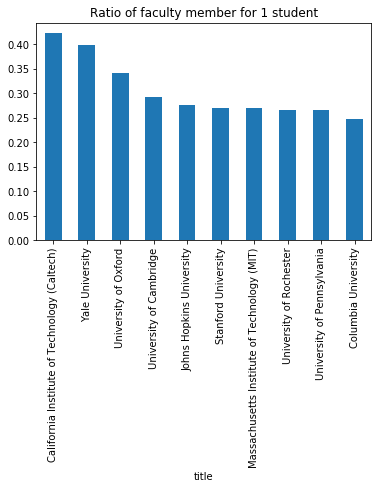

In [6]:
#helper function that compute the ratio of faculty member in function of students
def percentFacAndStud (row):
    return row['nbr_faculty_members']/row['nbr_total_students']
#helper function that compute the ratio of international students in function of total students
def percentInterAndStud (row):
    return row['nbr_international_total_students']/row['nbr_total_students']


#hard copy old DF and drop university that doesn't have the infromation required
filteredDataFrame1 = fullDataFrameTopUni200.copy()[['title','nbr_faculty_members','nbr_international_faculty_members','nbr_total_students','nbr_international_total_students']].dropna()

#create new row with the function percentFacAndStud to compute the ratio faculty member per student
filteredDataFrame1['ratio_faculty_per_student'] = filteredDataFrame1.apply (lambda row: percentFacAndStud (row),axis=1)
#create new row with the function percentInterAndStud to compute the ratio international students in function of total students
filteredDataFrame1['ratio_international_students'] = filteredDataFrame1.apply (lambda row: percentInterAndStud (row),axis=1)

#filter the result to answer question (a)
resultDataFrame=filteredDataFrame1[['title','ratio_faculty_per_student','nbr_faculty_members','nbr_total_students']]
#return the head of the dataframe, sorted by best ratio faculty per student
topRatioFacPerStudent = resultDataFrame.sort_values(by='ratio_faculty_per_student',ascending=False).head(10)

#plot them in a pie chart:
topRatioFacPerStudent = topRatioFacPerStudent.set_index('title')['ratio_faculty_per_student']
topRatioFacPerStudent.plot(kind='bar', title='Ratio of faculty member for 1 student')
plt.show()

** Result **
<br>
<font color='MidnightBlue'>

The top 3 universities in term of **ratio between faculty members and students** are : 
* California Institute of Technology (Caltech)
* Yale University
* University of Oxford



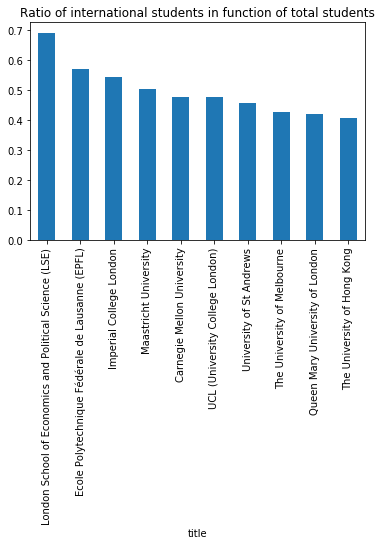

In [7]:
#filter the result to answer question (b)
resultDataFrame=filteredDataFrame1[['title','ratio_international_students','nbr_international_total_students','nbr_total_students']]
#return the head of the dataframe, sorted by best ratio faculty per student
topRatioInterStudents = resultDataFrame.sort_values(by='ratio_international_students',ascending=False).head(10)
#plot them in a pie chart:
topRatioInterStudents = topRatioInterStudents.set_index('title')['ratio_international_students']
topRatioInterStudents.plot(kind='bar', title='Ratio of international students in function of total students')
plt.show()

** Result **
<br>
<font color='MidnightBlue'>

The top 3 universities in term of **ratio of international students** are:
* London School of Economics and Political Science
* **Ecole Polytechnique Fédérale de Lausanne (EPFL)**	
* Imperial College London

## Answer the previous question aggregating the data by (c) country and (d) region.

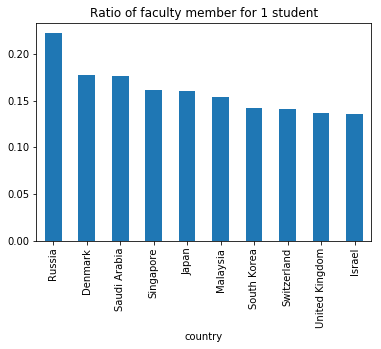

In [8]:
#filter the full dataFrame to only releveant parameters
filteredDataFrame1cd = fullDataFrameTopUni200.copy()[['country','region','nbr_faculty_members','nbr_international_faculty_members','nbr_total_students','nbr_international_total_students']]
#aggregate the countries for question (c)
countryDataFrame = filteredDataFrame1cd.drop('region',axis=1).groupby('country').agg('sum')

#the same helper functions are applied to create the 2 ratio into 2 new columns
countryDataFrame['ratio_faculty_per_student'] = countryDataFrame.apply (lambda row: percentFacAndStud (row),axis=1)
countryDataFrame['ratio_international_students'] = countryDataFrame.apply (lambda row: percentInterAndStud (row),axis=1)

topRatioFacPerStudent = countryDataFrame[['ratio_faculty_per_student','nbr_faculty_members','nbr_total_students']].sort_values(by='ratio_faculty_per_student',ascending=False).head(10)
#plot them in a pie chart:
topRatioFacPerStudent = topRatioFacPerStudent['ratio_faculty_per_student']
topRatioFacPerStudent.plot(kind='bar', title='Ratio of faculty member for 1 student')
plt.show()

** Result **
<br>
<font color='MidnightBlue'>
The top 3 countries in term of **ratio between faculty members and students** are:
* Russia
* Denmark
* Saudia Arabia

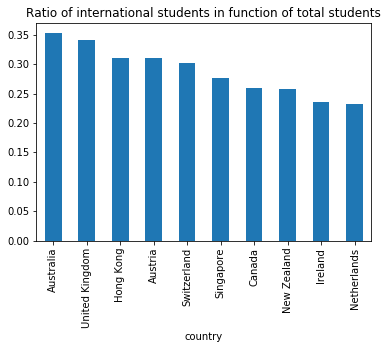

In [9]:
topRatioInterStudents = countryDataFrame[['ratio_international_students','nbr_international_total_students','nbr_total_students']].sort_values(by='ratio_international_students',ascending=False).head(10)
#plot them in a pie chart:
topRatioInterStudents = topRatioInterStudents['ratio_international_students']
topRatioInterStudents.plot(kind='bar', title='Ratio of international students in function of total students')
plt.show()

** Result **
<br>
<font color='MidnightBlue'>

The top 3 countries in term of **ratio of international students** are:
* Australia
* United Kingdom	
* Hong Kong

<font color='Black'>
## Answer the previous question for region. (d)
<br> 
** Method **
<font color='MidnightBlue'>
This code is similar to the code of question (c), but instead we aggregate on the label 'region' instead of 'country'.

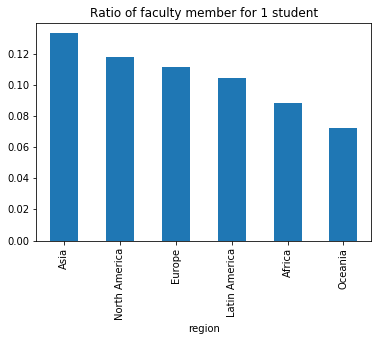

In [10]:
# same code as for the country, but with region
regionDataFrame = filteredDataFrame1cd.drop('country',axis=1).groupby('region').agg('sum')

#the same helper functions are applied to create the 2 ratio into 2 new columns
regionDataFrame['ratio_faculty_per_student'] = regionDataFrame.apply (lambda row: percentFacAndStud (row),axis=1)
regionDataFrame['ratio_international_students'] = regionDataFrame.apply (lambda row: percentInterAndStud (row),axis=1)
topRatioFacPerStudent = regionDataFrame[['ratio_faculty_per_student','nbr_faculty_members','nbr_total_students']].sort_values(by='ratio_faculty_per_student',ascending=False)
#plot them in a pie chart:
topRatioFacPerStudent = topRatioFacPerStudent['ratio_faculty_per_student']
topRatioFacPerStudent.plot(kind='bar', title='Ratio of faculty member for 1 student')
plt.show()

** Result **
<br>
<font color='MidnightBlue'>

The top 3 regions in term of **ratio between faculty members and students** are:
* Asia
* North America
* Europe

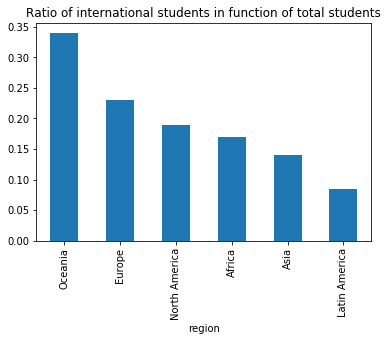

In [11]:
topRatioInterStudents = regionDataFrame[['ratio_international_students','nbr_international_total_students','nbr_total_students']].sort_values(by='ratio_international_students',ascending=False)
#plot them in a pie chart:
topRatioInterStudents = topRatioInterStudents['ratio_international_students']
topRatioInterStudents.plot(kind='bar', title='Ratio of international students in function of total students')
plt.show()

** Result **
<br>
<font color='MidnightBlue'>

The top 3 regions in term of **ratio of international students** are:
* Oceania
* Europe
* North America

# 2. Obtain the 200 top-ranking universities in www.timeshighereducation.com ([ranking 2018](http://timeshighereducation.com/world-university-rankings/2018/world-ranking)). Repeat the analysis of the previous point and discuss briefly what you observed.

Again using the postman plugin on google chrome, we found the json representing the list of the universities:


https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json

In [12]:
#json to dataframe using panda
json_data2 = json.load(open('TimesRanking.json'))
df2 = json_normalize(json_data2['data'])
#print(df2.T.index)
fullDataFrameTimes200 = df2.copy().head(200)
#clean the data converting string into int
fullDataFrameTimes200['stats_number_students'] = [int(x.replace(',','')) for x in fullDataFrameTimes200.stats_number_students]
fullDataFrameTimes200['stats_student_staff_ratio'] = [1/float(x) for x in fullDataFrameTimes200.stats_student_staff_ratio]
#change "38%" string into 0.38 int
def stringPercentToInt(elem):
    return float(elem.replace('%',''))/100
fullDataFrameTimes200['stats_pc_intl_students'] = [stringPercentToInt(x) for x in fullDataFrameTimes200.stats_pc_intl_students]
fullDataFrameTimes200.head(4)

aliases        location member_level  \
0                        University of Oxford  United Kingdom            0   
1                     University of Cambridge  United Kingdom            0   
2  California Institute of Technology caltech   United States            0   
3                         Stanford University   United States           11   

                                 name     nid rank rank_order     record_type  \
0                University of Oxford     468    1         10  master_account   
1             University of Cambridge     470    2         20  master_account   
2  California Institute of Technology  128779   =3         30         private   
3                 Stanford University     467   =3         40         private   

  scores_citations scores_citations_rank  \
0             99.1                    15   
1             97.5                    29   
2             99.5                    10   
3             99.9                     4   

                         ...                         scores_research  \
0                        ...                                    99.5   
1                        ...                                    97.8   
2                        ...                                    97.5   
3                        ...                                    96.7   

  scores_research_rank scores_teaching scores_teaching_rank  \
0                    1            86.7                    5   
1                    3            87.8                    3   
2                    4            90.3                    1   
3                    5            89.1                    2   

  stats_female_male_ratio stats_number_students stats_pc_intl_students  \
0                 46 : 54                 20409                   0.38   
1                 45 : 55                 18389                   0.35   
2                 31 : 69                  2209                   0.27   
3                 42 : 58                 15845                   0.22   

  stats_student_staff_ratio  \
0                  0.089286   
1                  0.091743   
2                  0.153846   
3                  0.133333   

                                    subjects_offered  \
0  Archaeology,Art, Performing Arts & Design,Biol...   
1  Archaeology,Architecture,Art, Performing Arts ...   
2  Architecture,Biological Sciences,Business & Ma...   
3  Archaeology,Architecture,Art, Performing Arts ...   

                                                 url  
0       /world-university-rankings/university-oxford  
1    /world-university-rankings/university-cambridge  
2  /world-university-rankings/california-institut...  
3     /world-university-rankings/stanford-university  

[4 rows x 26 columns]

** Remark**
<font color='MidnightBlue'>

Note that we changed **stats_student_staff_ratio** that represent the number of students for one faculty member to its inverse (1/stats_student_staff_ratio) : the number of **faculty member per student**. This way we have similar reference between this data frame and the one from TopUniversities.com.

The 2 ratios needed for the analysis are already there and there is no more relevant information in specific page of each universities.

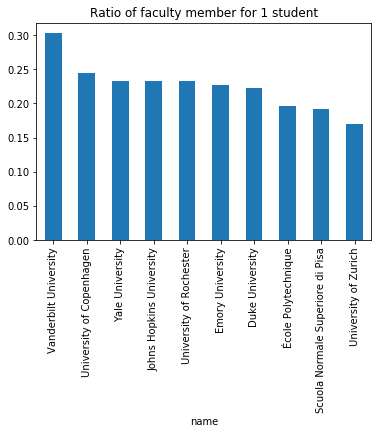

In [13]:
filteredDataFrame2 = fullDataFrameTimes200.copy()[['name','location','rank','stats_pc_intl_students','stats_student_staff_ratio','stats_number_students']]
#sort by ratio and rank too for tie
topRatioFacPerStudent = filteredDataFrame2.sort_values(by=['stats_student_staff_ratio','rank'],ascending=[False,True]).head(10)
#plot them in a pie chart:
topRatioFacPerStudent = topRatioFacPerStudent.set_index('name')['stats_student_staff_ratio']
topRatioFacPerStudent.plot(kind='bar', title='Ratio of faculty member for 1 student')
plt.show()

** Result **
<br>
<font color='MidnightBlue'>
The top 3 universities in term of **ratio between faculty members and students** are:
* Vanderbilt University
* University of Copenhagen
* Yale University

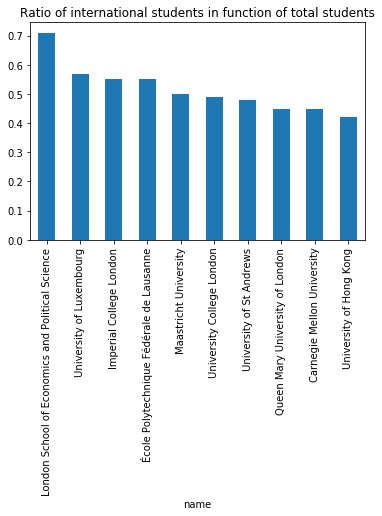

In [14]:
#sort by ratio and rank too for tie
topRatioInterStudents = filteredDataFrame2.sort_values(by=['stats_pc_intl_students','rank'],ascending=[False,True]).head(10)
#plot them in a pie chart:
topRatioInterStudents = topRatioInterStudents.set_index('name')['stats_pc_intl_students']
topRatioInterStudents.plot(kind='bar', title='Ratio of international students in function of total students')
plt.show()

** Result **
<font color='MidnightBlue'>
<br>
The top 3 universities in term of **ratio of international students** are:
* London School of Economics and Political Science
* University of Luxembourg	
* Imperial College London

In contrast with the first dataFrame, we only have the country to agreggate in this case. The problem is that we can't easily aggregate, because we can't just sum the percentage. So we will subtract the number of international student and the number of staff.

In [15]:
#helper function that compute the number of international students
def computeNbrInternationalStudent(row):
    #we floor because the percentage are approximated and floored.
    return int(np.floor(row['stats_pc_intl_students']*row['stats_number_students']))

#helper function that compute the number of staff member
def computeNbrStaffs(row):
    #we floor because the percentage are approximated and floored.
    return int(np.floor(row['stats_student_staff_ratio']*row['stats_number_students']))

#filter the full dataFrame to only releveant parameters 
fullDataFrameTimes200['stats_number_international_students'] = fullDataFrameTimes200.apply (lambda row: computeNbrInternationalStudent (row),axis=1)
fullDataFrameTimes200['stats_number_staffs'] = fullDataFrameTimes200.apply (lambda row: computeNbrStaffs (row),axis=1)

Note that we created 2 columns in the real data frame, maybe thoses data are useful for later. Now we can compute by aggregating like in exercice 1.

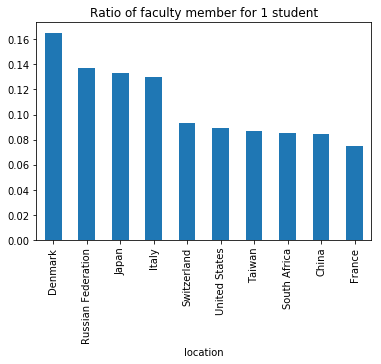

In [16]:
#helper function that compute the ratio of faculty member in function of students
def percentFacAndStud2 (row):
    return row['stats_number_staffs']/row['stats_number_students']
#helper function that compute the ratio of international students in function of total students
def percentInterAndStud2 (row):
    return row['stats_number_international_students']/row['stats_number_students']
#aggregate the countries for question (c)
countryDataFrame2 = fullDataFrameTimes200.copy()[['location','stats_number_international_students','stats_number_staffs','stats_number_students']]
countryDataFrame2 = countryDataFrame2.groupby('location').agg('sum')
#we use the helper functions to create the 2 ratio into 2 new columns
countryDataFrame2['ratio_faculty_per_student'] = countryDataFrame2.apply (lambda row: percentFacAndStud2 (row),axis=1)
countryDataFrame2['ratio_international_students'] = countryDataFrame2.apply (lambda row: percentInterAndStud2 (row),axis=1)
topRatioFacPerStudent = countryDataFrame2[['ratio_faculty_per_student','stats_number_staffs','stats_number_students']].sort_values(by='ratio_faculty_per_student',ascending=False).head(10)
#plot them in a pie chart:
topRatioFacPerStudent = topRatioFacPerStudent['ratio_faculty_per_student']
topRatioFacPerStudent.plot(kind='bar', title='Ratio of faculty member for 1 student')
plt.show()


** Result **
<font color='MidnightBlue'>
<br>
The top 3 country in term of **ratio between faculty members and students** are:
* Denmark
* Russia
* Japan

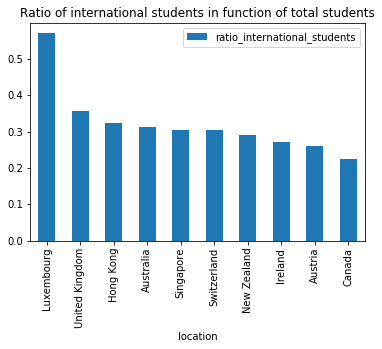

In [17]:
topRatioInterStudents = countryDataFrame2[['ratio_international_students']].sort_values(by='ratio_international_students',ascending=False).head(10)
#plot them in a pie chart:
topRatioInterStudents.plot(kind='bar', title='Ratio of international students in function of total students')
plt.show()

** Result **
<font color='MidnightBlue'>
<br>
The top 3 country in term of **ratio of international students** are:
* Luxembourg
* United Kingdom
* Hong Kong

<font color='Black'>
** Remark **
<br>
<font color='MidnightBlue'>
We notice that some results are different between the data of the 2 sites. There is 2 reasons for that:
* Some universities are not in both data sets, but still have a reallly good ratio. For example the University of Luxembourg (rank 179 and 2nd in ratio of international students) in the seconds site, but is inexistant in TimesUniversities.com.

* There is a difference between the 2 data frames in parameters that should be equivalent.
See next cell.

In [18]:
#data of the site TopUni
data1 = fullDataFrameTopUni200.set_index('title').loc[['Imperial College London','Ecole Polytechnique Fédérale de Lausanne (EPFL)'],['nbr_total_students','nbr_international_total_students']]
print("data of the site TopUni:")
print(data1.to_string())
#data of the site Times
data2 = fullDataFrameTimes200.set_index('name').loc[['Imperial College London','École Polytechnique Fédérale de Lausanne'],['stats_number_students','stats_number_international_students']]
print("-"*100)
print("data of the site Times:")
print(data2.to_string())

data of the site TopUni:
                                                nbr_total_students nbr_international_total_students
title                                                                                              
Imperial College London                                      16090                             8746
Ecole Polytechnique Fédérale de Lausanne (EPFL)              10343                             5896
----------------------------------------------------------------------------------------------------
data of the site Times:
                                          stats_number_students  stats_number_international_students
name                                                                                                
Imperial College London                                   15857                                 8721
École Polytechnique Fédérale de Lausanne                   9928                                 5460


** Remark **
<font color='MidnightBlue'>

Parameters that we think wont vary between the data set (number of students, number of international students,... ) are actually different. It's why the analyse of the 2 ratios between the two sites **return different results** in _Ex.1_ and _Ex.2_. This is maybe due to different standards for counting or to different data update dates.

### Now for the region:
We will use the first dataframe that has links between country and region to add a new region column in the database.

In [19]:
mapCountryRegion = fullDataFrameTopUni200.copy()[['region','country']].drop_duplicates(subset=['region', 'country'], keep='first')
mapCountryRegion = mapCountryRegion.set_index('country')

def createRegionUsingCountry(row):
    #we floor because the percentage are approximated and floored.
    return mapCountryRegion.region.get(row['location'], np.nan)

filteredDataFrame3 = fullDataFrameTimes200.copy()[['name','location']]
filteredDataFrame3['region'] = filteredDataFrame3.apply (lambda row: createRegionUsingCountry (row),axis=1)
#there is only 2 countries that are not in the first dataframe: russian federation and luxembourg, so we can add them by hand
#na_free = filteredDataFrame3.dropna()
#only_na = filteredDataFrame3[~filteredDataFrame3.index.isin(na_free.index)]
#only_na represent the list of country that have no regions
#only_na
#Russia
filteredDataFrame3 = filteredDataFrame3.set_index('name')
filteredDataFrame3.set_value('Lomonosov Moscow State University','region','Europe')
#Luxembourg
filteredDataFrame3.set_value('University of Luxembourg','region','Europe')

filteredDataFrame3

location  \
name                                                                     
University of Oxford                                    United Kingdom   
University of Cambridge                                 United Kingdom   
California Institute of Technology                       United States   
Stanford University                                      United States   
Massachusetts Institute of Technology                    United States   
Harvard University                                       United States   
Princeton University                                     United States   
Imperial College London                                 United Kingdom   
University of Chicago                                    United States   
ETH Zurich – Swiss Federal Institute of Technol...         Switzerland   
University of Pennsylvania                               United States   
Yale University                                          United States   
Johns Hopkins University                                 United States   
Columbia University                                      United States   
University of California, Los Angeles                    United States   
University College London                               United Kingdom   
Duke University                                          United States   
University of California, Berkeley                       United States   
Cornell University                                       United States   
Northwestern University                                  United States   
University of Michigan                                   United States   
National University of Singapore                             Singapore   
University of Toronto                                           Canada   
Carnegie Mellon University                               United States   
London School of Economics and Political Science        United Kingdom   
University of Washington                                 United States   
University of Edinburgh                                 United Kingdom   
New York University                                      United States   
Peking University                                                China   
Tsinghua University                                              China   
...                                                                ...   
University of Cape Town                                   South Africa   
Rutgers, the State University of New Jersey              United States   
KTH Royal Institute of Technology                               Sweden   
University of Münster                                          Germany   
Université Libre de Bruxelles                                  Belgium   
Newcastle University                                    United Kingdom   
University of Liverpool                                 United Kingdom   
Zhejiang University                                              China   
University of Luxembourg                                    Luxembourg   
University of Twente                                       Netherlands   
Paris-Sud University                                            France   
École Normale Supérieure de Lyon                                France   
Hong Kong Polytechnic University                             Hong Kong   
Scuola Normale Superiore di Pisa                                 Italy   
University of Aberdeen                                  United Kingdom   
University of Miami                                      United States   
University of Dundee                                    United Kingdom   
University of East Anglia                               United Kingdom   
Shanghai Jiao Tong University                                    China   
Aalto University                                               Finland   
University of Massachusetts                              United States   
University of Auckland                                     New Zea

# 3. merge datasets
Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

** Method**
<font color='MidnightBlue'> We have to merge data based on names which may slightly differ : different language, missing small linking words, re-ordered words... We need something to match the two list of names correctly.  

Our strategy here will be to build a UID (based on the country + name/title of the university). We improved iteratively our uid-generating function while back checking the set of "non-matching names/titles" at each iteration.  


it features : 
- case + accent + punctuation insensitivity
- short words removal / long words truncating / words sorting, meant to avoid the translation step for most words
- duplicated words removal
- some manual translation for some difficult words in the dataset


And here are the results at each iteration :  
- lower + accents             : 66 rows dropped in each dataset   
- . += short words removal    : 59        -----------   
- . += truncate words         : 55          -------------- all this helps to create a make-do translation  
- . += sort words             : 54           ----------------------          
- . += remove duplicate words : 53  
- . += impr. punctuation rem. : 51  
- . += manual translations    : 49


Important as well : our goal after that is to find correlations between the values of this dataset. We will actually find these correlations on values across datasets (i.e, corr(values_from_times, values_from_topUni). Therefore, it makes sense to keep only universities that exist in both rankings.

In [32]:
# removing equality symbol that is sometines in from of 'rank'
def correct_rank (obj):
    return int(obj.replace('=',''))


cleared_TopUni200 = fullDataFrameTopUni200.copy()
# we will use the ratios we computed previously later on
cleared_TopUni200['ratio_international_students'] = filteredDataFrame1['ratio_international_students']
cleared_TopUni200['ratio_faculty_per_student'] = filteredDataFrame1['ratio_faculty_per_student']
# now we clear the title and rank in terms of undesired signs and symbols
cleared_TopUni200['rank'] = [correct_rank(k) for k in cleared_TopUni200['rank_display']]
final_TopUni200 = cleared_TopUni200.drop('rank_display',1)

final_TopUni200.head(3)

country     nid         region score stars  \
0  United States  294850  North America   100     6   
1  United States  297282  North America  98.7     5   
2  United States  294270  North America  98.4     5   

                                         title  \
0  Massachusetts Institute of Technology (MIT)   
1                          Stanford University   
2                           Harvard University   

                                                 url nbr_faculty_members  \
0  /universities/massachusetts-institute-technolo...                2982   
1                  /universities/stanford-university                4285   
2                   /universities/harvard-university                4350   

  nbr_international_faculty_members nbr_total_students  \
0                              1679              11067   
1                              2042              15878   
2                              1311              22429   

  nbr_international_total_students  ratio_international_students  \
0                             3717                      0.335863   
1                             3611                      0.227422   
2                             5266                      0.234785   

   ratio_faculty_per_student  rank  
0                   0.269450     1  
1                   0.269870     2  
2                   0.193945     3

In [33]:
cleared_Times = fullDataFrameTimes200.copy()

# clear names and ranks
cleared_Times['rank'] = [correct_rank(k) for k in cleared_Times['rank']]
# rename interesting statistics to facilitate comparision between websites
final_Times = cleared_Times.rename(columns = {'stats_number_students':'nbr_total_students',
                                                'stats_number_international_students':'nbr_international_total_students',
                                                'stats_number_staffs':'nbr_faculty_members',
                                                'stats_pc_intl_students':'ratio_international_students',
                                                'stats_student_staff_ratio':'ratio_faculty_per_student',
                                                'location':'country',
                                                'name':'title'})
final_Times.head(3)

aliases         country member_level  \
0                        University of Oxford  United Kingdom            0   
1                     University of Cambridge  United Kingdom            0   
2  California Institute of Technology caltech   United States            0   

                                title     nid  rank rank_order  \
0                University of Oxford     468     1         10   
1             University of Cambridge     470     2         20   
2  California Institute of Technology  128779     3         30   

      record_type scores_citations scores_citations_rank         ...          \
0  master_account             99.1                    15         ...           
1  master_account             97.5                    29         ...           
2         private             99.5                    10         ...           

  scores_teaching scores_teaching_rank stats_female_male_ratio  \
0            86.7                    5                 46 : 54   
1            87.8                    3                 45 : 55   
2            90.3                    1                 31 : 69   

  nbr_total_students ratio_international_students ratio_faculty_per_student  \
0              20409                         0.38                  0.089286   
1              18389                         0.35                  0.091743   
2               2209                         0.27                  0.153846   

                                    subjects_offered  \
0  Archaeology,Art, Performing Arts & Design,Biol...   
1  Archaeology,Architecture,Art, Performing Arts ...   
2  Architecture,Biological Sciences,Business & Ma...   

                                                 url  \
0       /world-university-rankings/university-oxford   
1    /world-university-rankings/university-cambridge   
2  /world-university-rankings/california-institut...   

  nbr_international_total_students nbr_faculty_members  
0                             7755                1822  
1                             6436                1687  
2                              596                 339  

[3 rows x 28 columns]

<font color='MidnightBlue'>Now, here are helpers for the uid generator, followed by the generator itself. It's basically doing a long sequence of simple steps to create a uid.  
This UID is pretty good : We did two checks on the dataset :
- the number of rows merged together, and the number of rows that we know are being dropped actually sum up to 200, which means there are no "false negative" merges. E.g. 'ecole de commerce' and 'ecole de commerage' being incorrectly merged under the uid 'ecol_comm'.  
- we can look at the rejected data (rows that didn't find a match) and see that for the most part (all but ~2), they actually don't have a match. 

You will find these two checks implemented 3 and 4 cells forward.

In [34]:
# Helper : removes acronyms e.g (EPFL) at the end of Ecole Polytechnique Federale de Lausanne
def remove_acronyms (obj):
    # we first look for a sigle in the object (title)
    k = obj.find('(')-1
    if k > 0:
        return obj[0:k] #if there is a sigle we take the object until this symbol
    return obj

# Helper : removes accents (most common ones)
def remove_punctuation (obj):
    return (obj.replace('é','e').replace('è','e').replace('ó','o')
                .replace('ü','u').replace('ä','a').replace('&','')
                .replace('-',' ').replace('_',' ').replace(',', ' ')
                .replace('.',' ').replace(';',' ').replace('ò', 'o')
           )

# Helper : manual translation for some problematic words
def translate(word) : 
    return {
        'freie' : 'free',
        'vrije' : 'free',
        'libre' : 'free',
        'brussel' : 'bruxelles',
        'ida' : 'nahui'
    }.get(word, word) # default : return 'word'

In [35]:
"""
create UID based on university name. This UID aims to ignore : 
    - capitalization / accents
    - short, insignificant words (i.e : 'The london Uni' and 'London Uni' should yield the same UID)
    - language (i.e : Université de londre and London university)
    - words ordering (cf above)
"""
def create_uid(row) : 
    low = remove_punctuation(remove_acronyms(row['title'].lower()))
    split = low.split(' ')
    dedup = list(set(split))
    filtered = [s for s in dedup if(len(s)>3 or s.lower()=='new')]      # remove 'and', 'the', 'le', ...
    if(len(filtered)<=1) :                         # Avoid collisions if there are not enough long words
        filtered = dedup
    translated = [translate(w) for w in filtered]
    translated.sort()
    concat = "_".join([s[:6] for s in translated])   # makeshift for translation : e.g universidad, universitaet, university...
    #print("concat : ", concat)
    return row['country']+concat

In [36]:
# merge using our UIDs as index
final_TopUni200['uid']=final_TopUni200.apply(create_uid, axis=1)
final_Times['uid']=final_Times.apply(create_uid, axis=1)
merged_data = final_Times.merge(final_TopUni200,how = 'inner',suffixes=('_topUni', '_times'), on='uid')

print("number of accepted rows : ",merged_data.shape[0])
merged_data.head(3)

number of accepted rows :  150


aliases  country_topUni member_level  \
0                        University of Oxford  United Kingdom            0   
1                     University of Cambridge  United Kingdom            0   
2  California Institute of Technology caltech   United States            0   

                         title_topUni  nid_topUni  rank_topUni rank_order  \
0                University of Oxford         468            1         10   
1             University of Cambridge         470            2         20   
2  California Institute of Technology      128779            3         30   

      record_type scores_citations scores_citations_rank    ...     stars  \
0  master_account             99.1                    15    ...         5   
1  master_account             97.5                    29    ...         5   
2         private             99.5                    10    ...         5   

                                    title_times  \
0                          University of Oxford   
1                       University of Cambridge   
2  California Institute of Technology (Caltech)   

                                           url_times  \
0                    /universities/university-oxford   
1                 /universities/university-cambridge   
2  /universities/california-institute-technology-...   

  nbr_faculty_members_times nbr_international_faculty_members  \
0                      6750                              2964   
1                      5490                              2278   
2                       953                               350   

  nbr_total_students_times nbr_international_total_students_times  \
0                    19720                                   7353   
1                    18770                                   6699   
2                     2255                                    647   

  ratio_international_students_times ratio_faculty_per_student_times  \
0                           0.372870                        0.342292   
1                           0.356899                        0.292488   
2                           0.286918                        0.422616   

  rank_times  
0          6  
1          5  
2          4  

[3 rows x 43 columns]

In [37]:
# Check the number of dropped row, and verify manually that they are indeed not matching
times_dropped = final_Times[['country', 'title', 'uid']][~final_Times.uid.isin(final_TopUni200.uid.values)]#.sort_values('country')
topuni_dropped = final_TopUni200[['country', 'title', 'uid']][~final_TopUni200.uid.isin(final_Times.uid.values)]#.sort_values('country')
res = topuni_dropped.merge(times_dropped,how = 'outer',suffixes=('_topUni', '_times'), on=['country','uid'])

idx = 0  # print out rows [idx, idx+30]
print("Number of rejected rows : ",len(res.sort_values('country'))/2.0)
res.sort_values('country').head(30+idx).tail(30)

Number of rejected rows :  50.0


country                                   title_topUni  \
8   Argentina              Universidad de Buenos Aires (UBA)   
37  Australia                University of Technology Sydney   
41    Austria                Vienna University of Technology   
40     Brazil    Universidade Estadual de Campinas (Unicamp)   
16     Brazil                      Universidade de São Paulo   
25     Canada                         University of Waterloo   
49      Chile                           Universidad de Chile   
22      Chile  Pontificia Universidad Católica de Chile (UC)   
38     France                                CentraleSupélec   
56     France                                            NaN   
88     France                                            NaN   
3      France                Ecole normale supérieure, Paris   
96     France                                            NaN   
58    Germany                                            NaN   
54    Germany                                            NaN   
60    Germany                                            NaN   
51    Germany                                            NaN   
82    Germany                                            NaN   
75    Germany                                            NaN   
86    Germany                                            NaN   
74    Germany                                            NaN   
66    Germany                                            NaN   
70    Germany                                            NaN   
68    Germany                                            NaN   
30    Germany            Eberhard Karls Universität Tübingen   
57    Germany                                            NaN   
80    Germany                                            NaN   
34    Germany           Albert-Ludwigs-Universitaet Freiburg   
7     Germany          Ruprecht-Karls-Universität Heidelberg   
6     Germany         Ludwig-Maximilians-Universität München   

                                        uid  \
8              Argentinaaires_buenos_univer   
37            Australiasydney_techno_univer   
41              Austriatechno_univer_vienna   
40               Brazilcampin_estadu_univer   
16                       Brazilpaulo_univer   
25                      Canadauniver_waterl   
49                        Chilechile_univer   
22          Chilecatoli_chile_pontif_univer   
38                             Francecentra   
56  Francelettre_paris_resear_scienc_univer   
88                       Franceparis_univer   
3           Franceecole_normal_paris_superi   
96                Franceparis_sorbon_univer   
58                     Germanytubing_univer   
54                     Germanyheidel_univer   
60                       Germanybonn_univer   
51                        Germanylmu_munich   
82                     Germanyuniver_wurzbu   
75                        Germanyulm_univer   
86                     Germanymunste_univer   
74                         Germanydresde_tu   
66                     Germanymannhe_univer   
70                     Germanycologn_univer   
68              Germanyberlin_charit_univer   
30        Germanyeberha_karls_tubing_univer   
57                     Germanyfreibu_univer   
80              Germanyerlang_nuremb_univer   
34       Germanyalbert_freibu_ludwig_univer   
7         Germanyheidel_karls_ruprec_univer   
6        Germanyludwig_maximi_munche_univer   

                                          title_times  
8                                                 NaN  
37                                                NaN  
41                                                NaN  
40                                                NaN  
16                                                NaN  
25                                                NaN  
49                                                NaN  
22                                                NaN  
38                                                NaN  
56 

<font color='MidnightBlue'>Now that data has been merged, we have duplicated columns (country, title, name, alias, ...) that we need to get rid of.

At the end of this cell, there's still a mess of columns, which we will sort out in the next part

In [38]:
# In the end we want to remove duplicates, like countries
# supposing that the location is obviously the same even if the formulation may differ
merged_data.drop(['country_times','title_times'], axis=1, inplace=True)
merged_data.rename(columns={'country_topUni':'country', 'title_topUni':'title'}, inplace=True)
merged_data.set_index(['country','title'])
merged_data.columns

merged_data.shape

(150, 41)

# 4. Do correlation?

Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

** Method**<font color='MidnightBlue'> First, let's examine both ranking's data to find out what could be interresting to correlate. NB : By correlation, we mean "cross-correlation". It's self explanatory here and doesn't induce confusion, so we'll use the shorter "correlation" term later on.

It would be interesting to find out how some values correlate : 
- the ratio of international students with scores_international_outlook
- the ratio of faculty member per student with scores_teaching
- the number of faculty members with research_score

As a "Control experiment", we will also look at the correlation :
- the number of subjects offered and the score_industry_income

todo : 
- the ratio of international faculty members with scores_international_outlook

In [40]:
print(final_TopUni200.columns)
print(final_Times.columns)

Index(['country', 'nid', 'region', 'score', 'stars', 'title', 'url',
       'nbr_faculty_members', 'nbr_international_faculty_members',
       'nbr_total_students', 'nbr_international_total_students',
       'ratio_international_students', 'ratio_faculty_per_student', 'rank',
       'uid'],
      dtype='object')
Index(['aliases', 'country', 'member_level', 'title', 'nid', 'rank',
       'rank_order', 'record_type', 'scores_citations',
       'scores_citations_rank', 'scores_industry_income',
       'scores_industry_income_rank', 'scores_international_outlook',
       'scores_international_outlook_rank', 'scores_overall',
       'scores_overall_rank', 'scores_research', 'scores_research_rank',
       'scores_teaching', 'scores_teaching_rank', 'stats_female_male_ratio',
       'nbr_total_students', 'ratio_international_students',
       'ratio_faculty_per_student', 'subjects_offered', 'url',
       'nbr_international_total_students', 'nbr_faculty_members', 'uid'],
      dtype='object')


<font color='MidnightBlue'> We will cleanly merge the data of both rankings before we proceed

In [42]:
# The columns we will keep to produce stats on
stats_cols = [  # Fields that exist in both rankings -> will be merged
                'nid_topUni', 'nid_times',
                'rank_topUni', 'rank_times', 
                'nbr_total_students_topUni', 'nbr_total_students_times',
                'ratio_international_students_topUni', 'ratio_international_students_times', 
                'ratio_faculty_per_student_topUni', 'ratio_faculty_per_student_times',
                # Fields that exist in only one ranking
                # Since we merge both rankings, we can correlate values across rankings !
                'scores_international_outlook',
                'scores_teaching',
                #'nbr_faculty_members',
                'scores_research',
                'scores_industry_income',
                'subjects_offered',
                ]

# filter and copy the dataset
stats_data = merged_data[stats_cols].copy()

# Merge similar columns by averaging their values
def asFloat(serie) : return serie.apply(lambda e : float(e))
def avg_cols(dataframe, col1, col2, newColName) :
    # replace col1
    dataframe[col1] = (asFloat(dataframe[col1]) + asFloat(dataframe[col2]))/2.0
    dataframe.rename(columns={col1:newColName}, inplace=True)
    # drop col2
    dataframe.drop(col2, axis=1, inplace=True)  
    
# Process the data as necessary    
avg_cols(stats_data, 'nbr_total_students_topUni', 'nbr_total_students_times', 'nbr_total_students')   
avg_cols(stats_data, 'ratio_international_students_topUni', 'ratio_international_students_times', 'ratio_international_students')    
avg_cols(stats_data, 'ratio_faculty_per_student_topUni', 'ratio_faculty_per_student_times', 'ratio_faculty_per_student')    
def count_subjects(subjects) : 
    return len(subjects.split(','))
stats_data['subjects_offered'] = stats_data['subjects_offered'].apply(count_subjects)


stats_data.head(3)

nid_topUni nid_times  rank_topUni  rank_times  nbr_total_students  \
0         468    294654            1           6             20064.5   
1         470    294561            2           5             18579.5   
2      128779    294562            3           4              2232.0   

   ratio_international_students  ratio_faculty_per_student  \
0                      0.376435                   0.215789   
1                      0.353450                   0.192116   
2                      0.278459                   0.288231   

  scores_international_outlook scores_teaching scores_research  \
0                         95.0            86.7            99.5   
1                         93.0            87.8            97.8   
2                         59.7            90.3            97.5   

  scores_industry_income  subjects_offered  
0                   63.7                26  
1                   51.5                27  
2                   92.6                21

 TODO : interpolation des na

In [43]:
# a wrapper, for clean code
def correlate(col1, col2, dataframe=stats_data, silent=False) : 
    vals1 = asFloat(dataframe[col1].fillna(0))
    vals2 = asFloat(dataframe[col2].fillna(0))
    mean1 = np.mean(vals1)
    mean2 = np.mean(vals2)
    std1 = np.std(vals1)
    std2 = np.std(vals2)
    crossCorr = (1/len(vals1))*np.sum(((vals1-mean2)*(vals2-mean2)))*(1/(std1*std2))
    
    if(not silent) : print("\nThe correlation between",col1, "and", col2, "is", crossCorr)

In [45]:
#print(stats_data[['ratio_international_students', 'scores_international_outlook']].head(3))
correlate('ratio_international_students', 'scores_international_outlook')    
correlate('ratio_faculty_per_student', 'scores_teaching')
correlate('nbr_faculty_members', 'scores_research')

correlate('subjects_offered', 'scores_industry_income')


The correlation between ratio_international_students and scores_international_outlook is 0.780479729729

The correlation between ratio_faculty_per_student and scores_teaching is 0.44172815679


KeyError: 'nbr_faculty_members'

**Results**

The correlation (cross-correlation : https://en.wikipedia.org/wiki/Cross-correlation#Time_series_analysis) is a scalar number that lies within [-1, 1], 1 indicating that the two series change values similarily, 0, that there is no similarity in how their values change, and -1 that their values change in an opposite manner.

We expected the ratio of international students and the international outlook score to have a high correlation coefficient, and they do.  
Similarily, the number of faculty member per student is quite correlated with the teaching scores.  
todo research 

Finally, our "control experiment" shows that there is no strong correlation between the number of subjects teached, and the industry incom

# 5. Best university? (not EPFL)

Can you find the best university taking in consideration both rankings? Explain your approach.

In [ ]:
#harward or stuff
pass


